# Housing Prices

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import normaltest
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings(action="ignore")

from config import usr, pwd, url, port, db
import helpers as hp

%matplotlib inline

## Load Data
Load dataset used to create previously developed housing prices model.

In [2]:
df_model = pd.read_csv('housing_prices_pvalue_cut.csv')

Split data into features and target variable.

In [3]:
features = df_model.columns.tolist()
features.remove('saleprice_sd_bc_tk')
X = df_model.loc[:, features]
y = df_model['saleprice_sd_bc_tk']

## Oridinary Linear Regression (OLS)

In [4]:
hp.run_linear_model(LinearRegression, X, y, print_results=True)

Prediction Metrics:
* MAE = 0.054
* MSE = 0.005
* RMSE = 0.072
* MAPE = 2.608%


In [5]:
hp.compare_scores()

Comparing Scores:
 * train: 0.881
 * test: 0.886


## Ridge Regression
Now, use Ridge regression to regularize the model. First, use cross-validation and a grid search to find the best hyperparameters.

In [6]:
alpha_list = [2**x for x in list(range(10))]
df_grid = hp.grid_search(Ridge, X, y, alpha_list, num_folds=10)

In [7]:
df_grid

,alpha,mean_cv_score
0,1,0.861596
1,2,0.861092
2,4,0.859638
3,8,0.856280
4,16,0.849690
5,32,0.838553
6,64,0.822429
7,128,0.800194
8,256,0.765458
9,512,0.706674


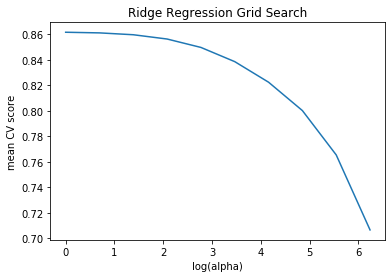

In [8]:
plt.plot(np.log(df_grid['alpha']), df_grid['mean_cv_score'])
plt.title('Ridge Regression Grid Search')
plt.xlabel('log(alpha)')
plt.ylabel('mean CV score')
plt.show()

**Observations:**

The lowest value of _alpha_ appears to be the best hyperparamter.

### Final Ridge Model

In [9]:
hp.run_linear_model(Ridge, X, y, alpha=1, print_results=True)

Prediction Metrics:
* MAE = 0.054
* MSE = 0.005
* RMSE = 0.072
* MAPE = 2.609%


In [10]:
hp.compare_scores()

Comparing Scores:
 * train: 0.881
 * test: 0.886


## Lasso Regression

In [11]:
alpha_list = [0.5*(10**(-1*x)) for x in list(range(7))]
alpha_list = [0] + alpha_list
df_grid = hp.grid_search(Lasso, X, y, alpha_list, num_folds=10)

In [12]:
df_grid

,alpha,mean_cv_score
0,0.000000e+00,0.861689
1,5.000000e-01,-0.013968
2,5.000000e-02,0.527104
3,5.000000e-03,0.805200
4,5.000000e-04,0.852088
5,5.000000e-05,0.861485
6,5.000000e-06,0.861687
7,5.000000e-07,0.861689


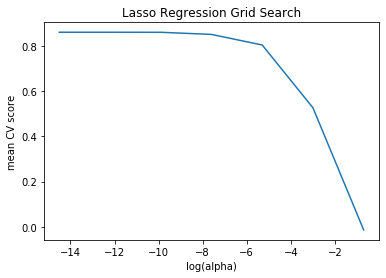

In [13]:
plt.plot(np.log(df_grid['alpha']), df_grid['mean_cv_score'])
plt.title('Lasso Regression Grid Search')
plt.xlabel('log(alpha)')
plt.ylabel('mean CV score')
plt.show()

**Observations:**

Again, the lowest value for _alpha_ appears to be the best. In this case, _alpha_ = 0, which is the same as the same as oridinary linear regression.

### Final Lasso Model

In [14]:
hp.run_linear_model(Lasso, X, y, alpha=0, print_results=True)

Prediction Metrics:
* MAE = 0.054
* MSE = 0.005
* RMSE = 0.072
* MAPE = 2.608%


In [15]:
hp.compare_scores()

Comparing Scores:
 * train: 0.881
 * test: 0.886


## Elastic Net

In [16]:
alpha_list = [0.5*(10**(-1*x)) for x in list(range(5))]
l1_ratio_list = [0.5*(10**(-1*x)) for x in list(range(5))]
df_grid = hp.grid_search(ElasticNet, X, y, alpha_list, l1_ratio_list=l1_ratio_list, num_folds=10)

In [17]:
df_grid.sort_values(by='mean_cv_score', ascending=False).head()

,alpha,mean_cv_score,l1_ratio
19,0.00050,0.861717,0.00005
18,0.00050,0.861716,0.00050
17,0.00050,0.861705,0.00500
24,0.00005,0.861703,0.00005
23,0.00005,0.861703,0.00050


In [18]:
df_grid['alpha_l1_ratio'] = df_grid['alpha'] + df_grid['l1_ratio']
df_grid = df_grid.sort_values(by='alpha_l1_ratio').copy()

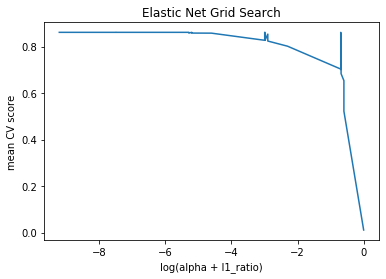

In [19]:
plt.plot(np.log(df_grid['alpha_l1_ratio']), df_grid['mean_cv_score'])
plt.title('Elastic Net Grid Search')
plt.xlabel('log(alpha + l1_ratio)')
plt.ylabel('mean CV score')
plt.show()

**Observations:**

The best hyperparameters for Elastic Net is when both _alpha_ and the _l1\__ratio_ are very small.

In [20]:
hp.run_linear_model(ElasticNet, X, y, alpha=5e-4, l1_ratio=5e-5, print_results=True)

Prediction Metrics:
* MAE = 0.054
* MSE = 0.005
* RMSE = 0.071
* MAPE = 2.607%


In [21]:
hp.compare_scores()

Comparing Scores:
 * train: 0.881
 * test: 0.886


## Conclusions
In all cases, the test R<sup>2</sup> score is the same. In addition, all the prediction metrics are the same for the final model, except the RMSE in Elastic Net, which is 0.001 worse. I can conclude the regularization does not have an affect on this model.